# Dataload & Imports

In [11]:
import pandas as pd
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [12]:
pump_station_data = pd.read_parquet("/home/s193864/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet")
pump_station_data.head(5)
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] > 0) & (pump_station_data["pump4_rpm"] == 0)]

In [13]:
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 

In [14]:
#import numpy as np
#pump_station_data.loc["2023-01-27 00:00:00.000000+00:00"]
#pump_station_data_subset = pump_station_data.iloc[946899:946899+86400]
#pump_station_data_subset2 = pump_station_data.iloc[946899+86400:946899+2*86400]
#n=0.5

#x_train, x_test = train_test_split(pump_station_data_subset, test_size=n)
#y_train, y_test = train_test_split(pump_station_data_subset2, test_size=n)


# Static Model


## Hvad vil vi modellere?
* Outflow over rpm
    * Pump1
    * Pump2
* Power over rpm
* Power over outflow

### Outflow as a function of pump speed.

In [15]:
x_train = train["pump1_rpm"].values.reshape(-1,1)
y_train = train["outflow"].values.reshape(-1,1)
x_test = test["pump1_rpm"].values.reshape(-1,1)
y_test = test["outflow"].values.reshape(-1,1)

mask = y_test >= 0.9*x_test-680
filtered_x = x_test[mask]
filtered_y = y_test[mask]

coefficients = np.polyfit(filtered_x, filtered_y, 1)

fit_curve = np.poly1d(coefficients)
x_series = np.arange(0, 1300, 1)
y_fit = coefficients[0]*x_series+coefficients[1]

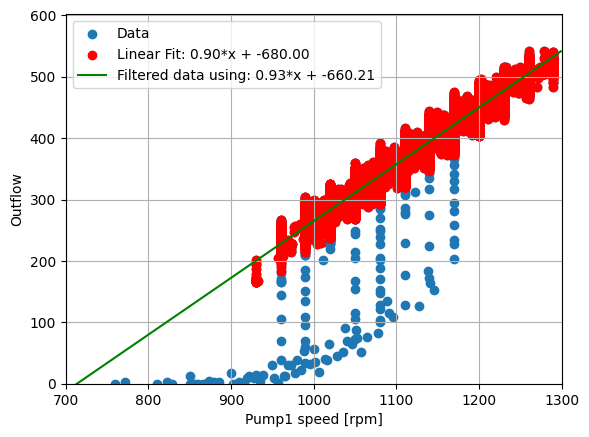

In [16]:
plt.scatter(y=y_test, x=x_test, label="Data")
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Linear Fit: {0.9:.2f}*x + {-680:.2f}')
plt.plot(y_fit, color="g", label=f'Filtered data using: {coefficients[0]:.2f}*x + {coefficients[1]:.2f}')
plt.legend()
plt.xlim(700, 1300)
plt.ylim(0)
plt.ylabel("Outflow")
plt.xlabel("Pump1 speed [rpm]")
plt.grid(True)

In [17]:
pump_station_data = pd.read_parquet("/home/s193864/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet")
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] == 0) & (pump_station_data["pump4_rpm"] > 0)]
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 
x_train = train["pump4_rpm"].values.reshape(-1,1)
y_train = train["outflow"].values.reshape(-1,1)
x_test = test["pump4_rpm"].values.reshape(-1,1)
y_test = test["outflow"].values.reshape(-1,1)


In [18]:

mask = y_test >= 1.17*x_test-800
filtered_x = x_test[mask]
filtered_y = y_test[mask]

coefficients = np.polyfit(filtered_x, filtered_y, 1)

fit_curve = np.poly1d(coefficients)
x_series = np.arange(0, 1400, 1)
y_fit = coefficients[0]*x_series+coefficients[1]

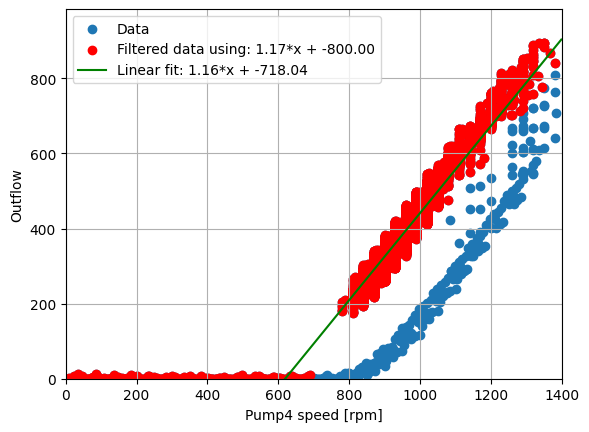

In [19]:
plt.scatter(y=y_test, x=x_test, label="Data")
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Filtered data using: {1.17:.2f}*x + {-800:.2f}')
plt.plot(y_fit, color="g", label=f'Linear fit: {coefficients[0]:.2f}*x + {coefficients[1]:.2f}')
plt.legend()
plt.xlim(0, 1400)
plt.ylim(0)
plt.ylabel("Outflow")
plt.xlabel("Pump4 speed [rpm]")
plt.grid(True)

### Power as a function of pump speed.

In [20]:
pump_station_data = pd.read_parquet("/home/s193864/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet")
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] == 0) & (pump_station_data["pump4_rpm"] > 0)]
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 
x_train = train["pump4_rpm"].values.reshape(-1,1)
y_train = train["pump4_power"].values.reshape(-1,1)
x_test = test["pump4_rpm"].values
y_test = test["pump4_power"].values

In [21]:
mask = x_test >= 300
filtered_x = x_test[mask]
filtered_y = y_test[mask]

coefficients = np.polyfit(filtered_x, filtered_y, 1)

fit_curve = np.poly1d(coefficients)
x_series = np.arange(0, 1400, 1)
y_fit = coefficients[0]*x_series+coefficients[1]

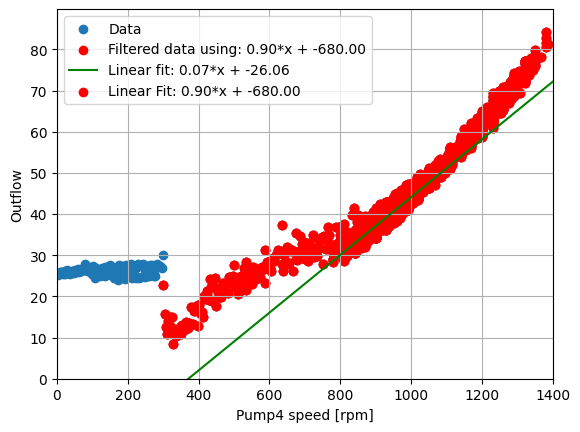

In [22]:
plt.scatter(y=y_test, x=x_test, label="Data")
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Filtered data using: {0.9:.2f}*x + {-680:.2f}')
plt.plot(y_fit, color="g", label=f'Linear fit: {coefficients[0]:.2f}*x + {coefficients[1]:.2f}')
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Linear Fit: {0.9:.2f}*x + {-680:.2f}')
plt.legend()
plt.xlim(0, 1400)
plt.ylim(0)
plt.ylabel("Outflow")
plt.xlabel("Pump4 speed [rpm]")
plt.grid(True)

# Dynamic Model

In [23]:
import pandas as pd 
from sysidentpy.model_structure_selection import FROLS 
from sysidentpy.basis_function._basis_function import Polynomial 
from sysidentpy.metrics import root_relative_squared_error 
from sysidentpy.utils.display_results import results



basis_function = Polynomial(degree=1)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)
model.fit(X=x_train, 
          y=y_train)




/home/s193864/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/s193864/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5
  self.info_values = self.information_criterion(reg_matrix, y)


In [24]:
yhat = model.predict(X=x_test, 
                     y=y_test,
                     forecast_horizon=60)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

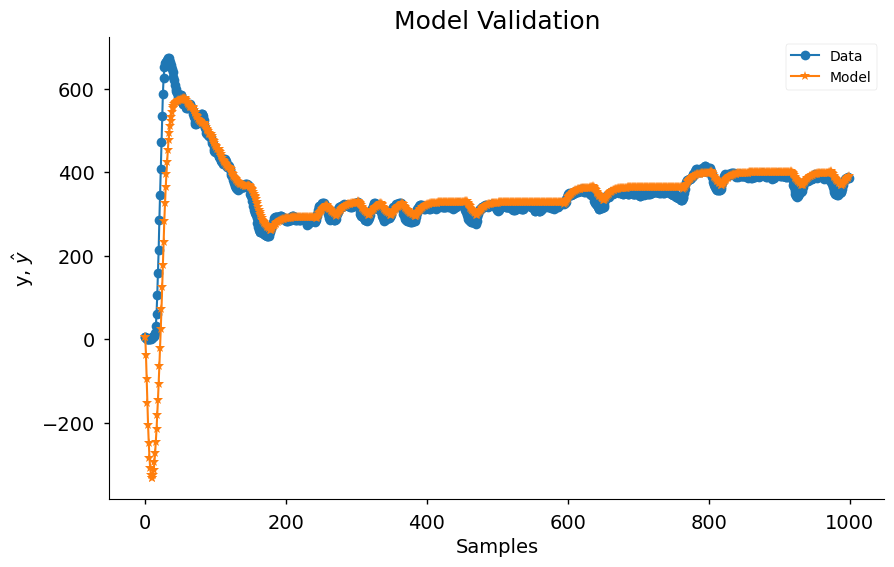

In [ ]:
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results

plot_results(y=y_test, yhat=yhat, n=1000, title="Model Validation",
    style='seaborn-v0_8-notebook',
    facecolor="white")

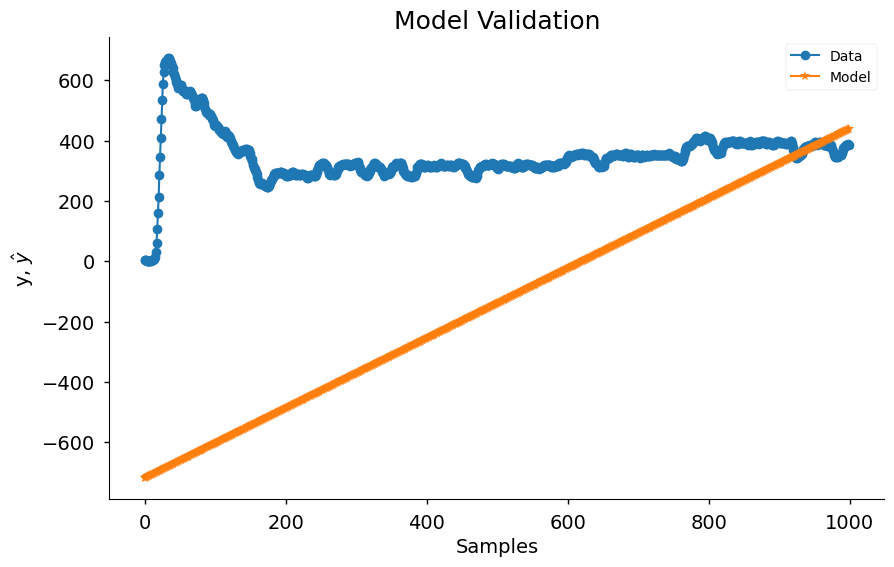

In [ ]:
plot_results(y=y_test, yhat=y_fit, n=1000, title="Model Validation",
    style='seaborn-v0_8-notebook',
    facecolor="white")

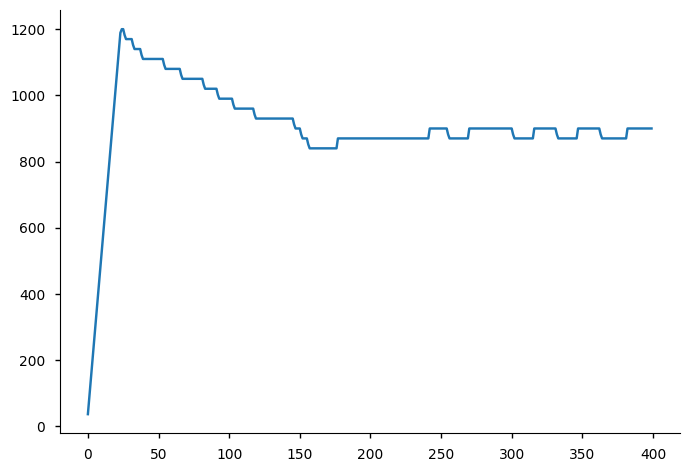

In [ ]:
plt.plot(x_test.squeeze()[:400])

In [ ]:


rrse = root_relative_squared_error(y_test, 
                                   yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

0.3264080352977859
  Regressors   Parameters             ERR
0     y(k-1)   1.4199E+00  9.99778112E-01
1     y(k-2)  -4.7275E-01  3.01380609E-05
2    x1(k-2)   1.7439E-01  1.65044455E-06
3          1  -3.9154E+01  1.49288586E-05
4    x1(k-1)  -1.1156E-01  5.69875404E-06


# Plots & Stuff

In [ ]:
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(name='Pump 1 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_rpm"])
fig.add_trace(go.Scattergl(name='Pump 4 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_rpm"])
#fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_power"])
#fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_power"])
#fig.add_trace(go.Scattergl(name='Height', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["height"])
#fig.add_trace(go.Scattergl(name='Outflow', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["outflow"])

fig

fig.update_layout(
    autosize=False,
    width=1200,
    height=750,
    font_family="TimesNewRoman",
    legend=dict(
        title=None, orientation="h", y=-0.40, yanchor="bottom", x=0.5 , xanchor="center", font_color="white"
    ),
    plot_bgcolor='#333',
    paper_bgcolor="#333",
    title="This is graph",
    title_font_color="white",
    title_font_size=30
)

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white"
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white",
    ticksuffix="[rpm]", showgrid=True
)

FigureWidgetResampler({
    'data': [{'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~1h</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': '604496fb-a7d3-4bb7-86a6-24a03aabee49',
              'x': array([datetime.datetime(2023, 1, 16, 1, 1, 49, 969000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 1, 1, 50, 969000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 3, 43, 55, 969000, tzinfo=<UTC>), ...,
                          datetime.datetime(2023, 3, 1, 22, 32, 39, 342000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 22, 55, 14, 342000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 23, 59, 59, 342000, tzinfo=<UTC>)],
                         dtype=object),
              'y': array([0., 0., 0., ..., 0., 0., 0.])},
             {'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~1h</i>'),
        

In [ ]:
fig = FigureWidgetResampler(go.Figure())
#fig.add_trace(go.Scattergl(name='Pump 1 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_rpm"])
#fig.add_trace(go.Scattergl(name='Pump 4 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_rpm"])
fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_power"])
fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_power"])
#fig.add_trace(go.Scattergl(name='Height', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["height"])
#fig.add_trace(go.Scattergl(name='Outflow', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["outflow"])

fig

fig.update_layout(
    autosize=False,
    width=1200,
    height=750,
    font_family="TimesNewRoman",
    legend=dict(
        title=None, orientation="h", y=-0.40, yanchor="bottom", x=0.5 , xanchor="center", font_color="white"
    ),
    plot_bgcolor='#333',
    paper_bgcolor="#333",
    title="This is graph",
    title_font_color="white",
    title_font_size=30
)

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white"
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white",
    ticksuffix="[kW]", showgrid=True
)

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> Pump 1 [kW] <i style="color:#fc9944">~1h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '046ecc2a-b30b-4635-874c-bdb84dbe05e7',
              'x': array([datetime.datetime(2023, 1, 16, 1, 1, 49, 969000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 1, 1, 50, 969000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 3, 43, 55, 969000, tzinfo=<UTC>), ...,
                          datetime.datetime(2023, 3, 1, 22, 32, 39, 342000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 22, 55, 14, 342000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 23, 59, 59, 342000, tzinfo=<UTC>)],
                         dtype=object),
              'y': array([0., 0., 0., ..., 0., 0., 0.])},
             {'name': '<b style="color:sandybrown">[R]</b> Pump 1 [kW] <i style="color:#fc99

In [ ]:
fig = FigureWidgetResampler(make_subplots(rows=4, cols=1, shared_xaxes=True))

#fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_power"])

fig.add_trace(go.Scattergl(name='Pump 1 [rpm]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump1_rpm"], 
        row=1, 
        col=1
        )
fig.add_trace(go.Scattergl(name='Pump 4 [rpm]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump4_rpm"], 
        row=1, 
        col=1)

fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump1_power"], 
        row=2, 
        col=1
        )
fig.add_trace(go.Scattergl(name='Pump 4 [kW]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump4_power"], 
        row=2, 
        col=1)
fig.add_trace(go.Scattergl(name='Height', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["height"], 
        row=3, 
        col=1
        )

fig.add_trace(go.Scattergl(name='Outflow', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["outflow"], 
        row=4, 
        col=1)

fig.update_layout(height=1200, width=1200, title_text="Stacked Subplots")
fig.show()

NameError: name 'pump_station_data_subset' is not defined